# Compilation time : a comparison

This is a set of functions that perform a comparison of computation time between NumPy, Jax and SPM's sophisticated inference agents in the "maze X" environment (soft maze, large number of hidden states).

Important things to note : 
- The results **will** be different depending on the hardware. In particular, this will depend on the CPU used for the notebook computations and the Matlab script (that is run separately!). The figures obtained here were obtained using an i5-11400H 2.70GHz. 
- You can run Jax functions on GPUs or TPUs. This was not done here. This may however result in significant improvements when computating over tensors of large sizes !
- The computation performed by the Jax implementation and the numpy/matlab implementations are **not the same** ! Out jax sophisticated inference algorithm uses a **fixed size tree** which always explores a subset of the potential actions & states for each new exploration node, thus performing a more complete (but also more expensive) search.



### Notes on Jax processing : 

- **CPUs** : A [nice introduction](https://bnikolic.co.uk/blog/python/jax/2023/03/22/jax-multithreaded.html) on how does Jax CPU multithreading work
- **Multi-process** : The [official documentation](https://jax.readthedocs.io/en/latest/multi_process.html) on distributed computations (that may be useful if you want to parrallelize your synthetic subject pool !)

In [1]:
# First, let's import stuff !
# Python "classics": 
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle # saving shenanigans
from functools import partial

# Import the necessary jax libraries : 
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import vmap,jit

# We want to measure execution times ! 
import timeit

# Active Inference based packages :
import actynf # import active-pynference package
print("Imported active-pynference - version " + actynf.__version__)

# The usual components of our sophisticated inference implementation : 
from actynf import layer,link
from actynf import layer_network as network

# The jax functions that allow us to run jax sophisticated inference training simulations
# Not yet incorporated into the generic layer class :(
from actynf.jax_methods.layer_options import get_planning_options,get_action_selection_options,get_learning_options
from actynf.jax_methods.layer_training import synthetic_training





# The weights for the maze :
from actynf.demo_tools.tmaze.weights import get_T_maze_gen_process,get_T_maze_model,get_jax_T_maze_model

COMPUTE_TIMES_SAVEPATH = os.path.join(".","local_resources","tmaze","compute_times")
FIGURES_SAVEPATH = os.path.join(".","local_resources","tmaze","renders")

Imported active-pynference - version 0.1.39


c:\Users\annic\OneDrive\Bureau\MainPhD\code\venvs\jax_new\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Just like in the other demo, the weights depend on scalar parameters describing the properties of the true environment as well as the initial model of the artificial mouse : 

For the environment (process) :
- $p_{init}$ is the probability of the reward being on the right at the beginning.
- $p_{HA}$ is the probability of the clue showing the right (resp. left) when the reward is on the right (resp.left).
- $p_{win}$ is the probability of getting a positive (resp. adversive) stimulus when picking the reward (resp. the shock).

For the mouse model : 
- $p_{HA}$ is the mouse belief about the mapping of the clue
- *initial_hint_confidence* is the strenght of this belief
- $la$,$rs$ are the agent priors about receiving adversive vs positive stimuli.
- $p_{win}$ is the mouse belief about probability of getting a positive (resp. negative) stimulus when picking the reward (resp. the shock).
- *context_belief* is where the mouse thinks the reward spawns at the beginning of each trial.

In [2]:
T = 3
Th = 2

# Those weights will remain the same for the whole notebook :
true_process_pHA = 1.0
true_process_pinit = 1.0
true_process_pwin = 0.98  # For a bit of noise !

true_A,true_B,true_D,U = get_T_maze_gen_process(true_process_pinit,true_process_pHA,true_process_pwin)


true_model_pHA = 1.0
true_model_pwin = 0.98
true_model_context_belief = 0.5
true_model_hint_conf = 2.0
true_model_la = -4.0
true_model_rs = 2.0

true_a,true_b,true_c,true_d,true_e,_ = get_T_maze_model(true_model_pHA,true_model_pwin,true_model_hint_conf,
                                        true_model_la,true_model_rs,true_model_context_belief)


We are interested in the run time for simulations following 3 parameters : the amount of subjects we will simulate (an obvious Jax strong point), the amount of trial simulated, and the complexity of the tree planning (i.e. how many branches are computed during planning). This is guided by the subject representation of the maze. We thus introduce (artificial) uncertainty regarding state transitions to manually reduce the amount of tree pruning performed during sophisticated planning.
- **Parameter 1 :** $N_{subj}$, will take values [10,50,100,500,1000,10000]
- **Parameter 2 :** $N_{trials}$ will take values [20,50,100]
- **Parameter 3 :** $p_{transition}$ describes the probability of actually moving to the expected cell given a specific action. It will take values [1.0,0.5], with $p_{transition}=0.5$ creating 2 additionnal state branches during planning (significantly increasing the complexity of the sophisticated planning).

In [22]:
def tensorify(*args):
    """ A very ugly function that transforms numpy arrays into jax tensors, while conserving list structures."""
    all_results = []
    for arg in args :
        if type(arg)==list :
            # We return a list of tensorified args :
            return_list = []
            for el in arg :
                return_list.append(tensorify(el))
            all_results.append(return_list)
        else :
            all_results.append(jnp.array(arg))
    
    if len(all_results)==1:
        return all_results[0]
    else :
        return tuple(all_results)

def check_save_exists(candidate,savepath):
    check_attributes = ["Th","N_subjs","N_trials","sample_size","method"] # No lists or classes !
    with open(savepath, 'rb') as handle:
        list_of_saves = pickle.load(handle)
        assert type(list_of_saves), "This file should be a list..."
        for existing_save in list_of_saves:
            same_specs = [candidate[attr]==existing_save[attr] for attr in check_attributes]
            if all(same_specs):
                return True,existing_save
    return False,None

def jax_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,
                 Nsubj,Ntrials):
    """ 
    Build a jax sophisticated inference network and run it. Also provide the running time !
    Warning : measuring execution times in jax is a bit trickier than in regular numpy due to 
    the asynchronous execution. We use block_until_ready() to ensure all results are computed !
    We also jit the function and run it once to precompile it.
    """
    # Training options :
    Sh = 1                      # State horizon (or the number of inidividual states that will create their own branch)
    remainder_state_bool = True # Do we create an additional branch with the remaining potential state density ?
    Ph = 5                      # Policy horizon (or the number of individual actions that will be explored at each node)
    option_a_nov = False
    option_b_nov = False
    additional_options_planning = False    

    planning_options = get_planning_options(Th,"classic",#"sophisticated",
                            Sh,Ph,remainder_state_bool,
                            option_a_nov,option_b_nov,additional_options_planning)

    as_options = get_action_selection_options("stochastic",alpha=16)

    learn_a,learn_b,learn_d = True,False,True
    learn_options = get_learning_options(learn_a,learn_b,learn_d,run_smoother=True)

    training_parrallel_func = partial(synthetic_training,
        Ntrials=Ntrials,T=T,
        A=A,B=B,D=D,U=U,
        a0=a,b0=b,c=c,d0=d,e=e,
        planning_options=planning_options,
        action_selection_options = as_options,
        learning_options = learn_options)
    jitted_training = jit(training_parrallel_func)
    
    # compil_start = timeit.default_timer()
    # rngkey_prime = jr.PRNGKey(0)
    # res = jitted_training(rngkey_prime)
    # res[0][0].block_until_ready()
    # compil_end = timeit.default_timer()
    
    # compiltime = compil_end-compil_start
    # print(f"compilation took {compiltime:.3f} s")
    
    all_keys = jr.split(jr.PRNGKey(np.random.randint(0,10000)),Nsubj)
    parrallel_start = timeit.default_timer()
    res_multiple = vmap(jitted_training)(all_keys)
    parrallel_end = timeit.default_timer()
    runtime = parrallel_end-parrallel_start   
    print(f"running {Nsubj:02} subjects took {runtime:.3f} s")  
    
    # Manual VMAP : 
    # total = 0
    # all_keys = jr.split(jr.PRNGKey(np.random.randint(0,100)),Nsubj)
    # for subj in range(Nsubj):
    #     parrallel_start = timeit.default_timer()
        
    #     res_multiple = jitted_training(all_keys[subj])
    #     res_multiple[0][0].block_until_ready()
    #     parrallel_end = timeit.default_timer()
        
    #     runtime = parrallel_end-parrallel_start
    #     print(f"running subject {subj:02} took {runtime:.3f} s")
    #     total = total + runtime
    # print(total)
    return [0,runtime],res_multiple
    
def numpy_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,
                 Nsubj,Ntrials):
    """ Build a numpy sophisticated inference network and run it. Also provide the running time !"""
    
    # Setting up the network, we ignore this
    seed = np.random.randint(0,9999)
    maze_process = layer("T-maze_environment","process",A,B,C,D,E,U,T,Th,in_seed=seed)
    seed = np.random.randint(0,9999)
    maze_model = layer("mouse_model","model",
                a,b,c,d,e,U,T,Th,in_seed=seed)
    
    maze_model.learn_options.learn_a = True
    maze_model.learn_options.learn_b = False
    maze_model.learn_options.learn_d = True
    maze_model.hyperparams.alpha = 16
    maze_model.hyperparams.a_novelty = True
    maze_model.learn_options.backwards_pass = True

    maze_process.inputs.u = link(maze_model,lambda x : x.u)
    maze_model.inputs.o = link(maze_process,lambda x : x.o)

    maze_net = network([maze_process,maze_model],"t-maze")
    
    
    rez = {"stms":[],"weights":[]}
    
    # Start measuring time now !
    start = timeit.default_timer()
    
    
    for sub in range(Nsubj):
        subj_net = maze_net.copy_network(sub)

        subj_net.run_N_trials(Ntrials,return_STMs=False,return_weights=False)
        # rez["stms"].append(STMs)
        # rez["weights"].append(weights) let's not record it, memory issues
        
    stop = timeit.default_timer()
    
    return stop-start,rez

def testing_bench(path,N_subjs,N_trials,Th,method="numpy",sample_size = 10,override= False):
    """ I am a timing comparator :D """
    # Ensure the folders + file we save all results to exists (should only be triggered once)
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))
    
    if not os.path.isfile(path):
        emptylist = []
        with open(path, 'wb') as handle:
            pickle.dump(emptylist, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # This is the set of parameters we're testing
    save_container = {
        "Th": Th,
        "N_subjs" : N_subjs,
        "N_trials" : N_trials,
        "sample_size" : sample_size,
        "method" : method,
        "delta_t" : []
    }
    
    # Check if it already exists
    already_exists,existing_container_if_exists = check_save_exists(save_container,path)
    if already_exists and (not(override)):
        # print("Already recorded performances, bypassing ... If you want to record again, enable override !")
        return existing_container_if_exists

    # Those weights will remain the same for the whole notebook :
    true_process_pHA = 1.0
    true_process_pinit = 1.0
    true_process_pwin = 0.98  # For a bit of noise !
    
    true_A,true_B,true_D,U = get_T_maze_gen_process(true_process_pinit,true_process_pHA,true_process_pwin)


    true_model_pHA = 1.0
    true_model_pwin = 0.98
    true_model_context_belief = 0.5
    true_model_hint_conf = 2.0
    true_model_la = -4.0
    true_model_rs = 2.0

    true_a,true_b,true_c,true_d,true_e,u = get_T_maze_model(true_model_pHA,true_model_pwin,true_model_hint_conf,
                                            true_model_la,true_model_rs,true_model_context_belief)
    
    
    if method=="numpy":
        A,B,C,D,E,U =true_A,true_B,true_c,true_D,true_e,U
        a,b,c,d,e,u = true_a,true_b,true_c,true_d,true_e,u
        for sample in range(sample_size):
            deltat_t, results = numpy_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,N_subjs,N_trials)
            save_container["delta_t"].append(deltat_t)
            
    elif method =="jax":
        A,B,C,D,E,U = tensorify(true_A,true_B,true_c,true_D,true_e,U)
        a,b,c,d,e,u = tensorify(true_a,true_b,true_c,true_d,true_e,u)

        print(u)
        print(U)
        
        for sample in range(sample_size):
            print(sample)
            deltat_t, results = jax_si_timewrapper(A,B,C,D,E,U,a,b,c,d,e,T,Th,N_subjs,N_trials)
            save_container["delta_t"].append(deltat_t)
            print(results[0][0].shape)
    
    elif method =="matlab":
        save_container["delta_t"].append(0)
        print("We don't run Matlab script from here :( \n TODO : load results generated using the SPM package here")
        raise NotImplementedError("Loading pipeline todo")
    
    else : 
        raise NotImplementedError("This sophisticated planning implementation has not been implemented")
    
    
    # Save the container : 
    with open(path, 'rb') as handle:
        list_of_existing_containers = pickle.load(handle)
        
    list_of_existing_containers.append(save_container)
    
    with open(path, 'wb') as handle:
        pickle.dump(list_of_existing_containers, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Saved timing results to :   " + path)
    return save_container


(3, 3, 10, 1)
(3, 3, 10)
(90, 1)
[0.00646598]
1.2508874433325836
(90, 1)
(350,)
(350, 1)


Text(0, 0.5, 'Computation time (s)')

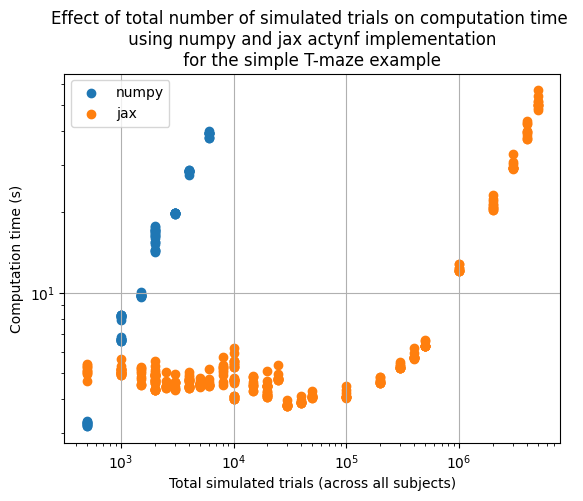

In [47]:
save_to_this_folder = os.path.join(COMPUTE_TIMES_SAVEPATH,"saved_chronos_no_compil")
N = 10
T = 3
Th = 2

number_of_trials_array = np.array([10,20,30,40,50])
number_of_subjects_array = np.array( [50,100,200,500,1000,10000,100000])

# Generate containers of runtime data :
jax_results = []
jax_predictors = []
for Ntrials in number_of_trials_array:
    jax_results.append([])
    jax_predictors.append([])
    for Nsub in number_of_subjects_array:
        cont = (testing_bench(save_to_this_folder,Nsub,Ntrials,Th,'jax',N,override=False))
        times = cont["delta_t"]
        # jax_results[-1].append(times)
        
        jax_predictors[-1].append([])
        jax_results[-1].append([])
        for result in times :
            jax_results[-1][-1].append(result)
            jax_predictors[-1][-1].append([Ntrials*Nsub])
jax_results = np.array(jax_results)[...,1]
jax_predictors = np.array(jax_predictors)

jax_predictors = np.reshape(jax_predictors,(-1,jax_predictors.shape[-1]))
jax_results = np.reshape(jax_results,(-1,))


# Bigger values cause notebook malfunction ? :(
reduced_number_of_trials_array = np.array([10,20,30])
reduced_number_of_subjects_array = np.array( [50,100,200])

numpy_results = []
numpy_predictors = []
for Ntrials in reduced_number_of_trials_array:
    numpy_results.append([])
    numpy_predictors.append([])
    for Nsub in reduced_number_of_subjects_array:
        cont = (testing_bench(save_to_this_folder,Nsub,Ntrials,Th,'numpy',N,override=False))
        times = cont["delta_t"]
        
        numpy_predictors[-1].append([])
        numpy_results[-1].append([])
        for result in times :
            numpy_results[-1][-1].append(result)
            numpy_predictors[-1][-1].append([Ntrials*Nsub])

numpy_predictors = np.array(numpy_predictors)
numpy_results = np.array(numpy_results)
print(numpy_predictors.shape)
print(numpy_results.shape)

numpy_predictors = np.reshape(numpy_predictors,(-1,numpy_predictors.shape[-1]))
numpy_results = np.reshape(numpy_results,(-1,))

print(numpy_predictors.shape)


from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(numpy_predictors,numpy_results)
print(reg.coef_)
print(reg.intercept_)
print(numpy_predictors.shape)
plt.scatter(numpy_predictors[...,0],numpy_results,label="numpy")
print(jax_results.shape)
print(jax_predictors.shape)
plt.scatter(jax_predictors[...,0],jax_results,label="jax")
plt.xscale('log')

plt.yscale('log')

plt.grid()
plt.legend()
plt.title("Effect of total number of simulated trials on computation time \n using numpy and jax actynf implementation \n for the simple T-maze example ")
plt.xlabel("Total simulated trials (across all subjects)")
plt.ylabel("Computation time (s)")


In [ ]:

# width = 0.35  # the width of the bars
# for i,Nsub in enumerate(reduced_number_of_subjects_array):
# 
#     fig, ax = plt.subplots()
#     rects1 = ax.bar(number_of_trials_array - width/2, np.mean(jax_results,axis=-1), width, yerr=np.std(jax_results,axis=-1),
#                     label='Jax')
#     rects2 = ax.bar(reduced_number_of_subjects_array + width/2, np.mean(jax_results,axis=-1), width, yerr=np.std(jax_results,axis=-1),
#                     label='Numpy')

#     # Add some text for labels, title and custom x-axis tick labels, etc.
#     ax.grid()
#     ax.set_ylabel('Scores')
#     ax.set_title('Scores by group and gender')
#     ax.set_xticks(number_of_trials_array)
#     # ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
#     ax.legend()


# # def autolabel(rects, xpos='center'):
# #     """
# #     Attach a text label above each bar in *rects*, displaying its height.

# #     *xpos* indicates which side to place the text w.r.t. the center of
# #     the bar. It can be one of the following {'center', 'right', 'left'}.
# #     """

# #     ha = {'center': 'center', 'right': 'left', 'left': 'right'}
# #     offset = {'center': 0, 'right': 1, 'left': -1}

# #     for rect in rects:
# #         height = rect.get_height()
# #         ax.annotate('{}'.format(height),
# #                     xy=(rect.get_x() + rect.get_width() / 2, height),
# #                     xytext=(offset[xpos]*3, 3),  # use 3 points offset
# #                     textcoords="offset points",  # in both directions
# #                     ha=ha[xpos], va='bottom')


# # autolabel(rects1, "left")
# # autolabel(rects2, "right")

# fig.tight_layout()

# plt.show()